In [1]:
def geography(left, right, bottom, top, resolution=12):
    """
    指定された緯度・経度範囲を基に、データグリッドのインデックスを計算する関数。
    """
    upperindex = int((90 - top) * resolution)
    lowerindex = int((90 - bottom) * resolution)
    leftindex = int((180 + left) * resolution)
    rightindex = int((180 + right) * resolution)

    rgnshape = (lowerindex - upperindex, rightindex - leftindex)
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

In [28]:
import os
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

city_num = 15
remove_grid = 5 # minimum number of grids in one basin
innercity_grid = 2 # minimum number of main river grid within city mask
left, right, bottom, top = 26, 34, 37, 43
leftlim, rightlim, bottomlim, toplim = 27, 32, 39, 43
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
mask_path = f'{h08dir}/camacity/dat/cty_msk_/city_clrd0000.gl5'
mask = np.fromfile(mask_path, dtype='float32').reshape(2160, 4320) 
mask_cropped = mask[upperindex:lowerindex, leftindex:rightindex]
mask_cropped = np.where(mask_cropped==city_num, 1, 0)

In [3]:
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='black', inner_color='black', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    if ax is None:
        # figure
        fig = plt.figure(figsize=(5,5))
        ax = plt.subplot(projection=projection)
        ax.coastlines(zorder=1)
        ax.set_extent(extent)
        ax.gridlines(draw_labels=True, zorder=0)
        ax.add_feature(cfea.OCEAN, color='#BBBBBB')
        ax.add_feature(cfea.LAKES, color='#BBBBBB')
        ax.set_xlim(leftlim, rightlim)
        ax.set_ylim(bottomlim, toplim)
        
    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # right

    if ax is None:
        plt.show()
    else:
        return ax

CPU times: user 103 ms, sys: 3.28 ms, total: 106 ms
Wall time: 119 ms


<GeoAxes: >

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


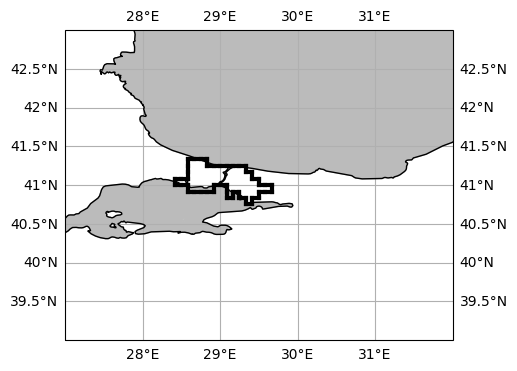

In [4]:
%time draw_mask_sotowaku(img_extent, mask_cropped, ax=None, sotowaku_color='black', inner_color='black', linewidth=3)

In [5]:
def nxtl2nxtxy(rivnxl, 
               upperindex, lowerindex, leftindex, rightindex, 
               a=2160, b=4320, nan_value = 1e20):
    # region
    rivnxl_cropped = rivnxl[upperindex:lowerindex, leftindex:rightindex]
    H, W = rivnxl_cropped.shape
    rivnxl_cropped[rivnxl_cropped < 10] = np.nan

    # L -> (y, x)
    mask = ~np.isnan(rivnxl_cropped)
    riv_flat = rivnxl_cropped[mask].astype(int) # 1次元に変換
    lat_l = (riv_flat - 1)  // b
    lon_l = (riv_flat - 1) % b
    lat_l = lat_l.astype(float)
    lon_l = lon_l.astype(float)

    # offset
    lat_l -= upperindex
    lon_l -= leftindex

    # 範囲外のセルをNaNにする
    out_of_bounds_mask = (lat_l < 0) | (lat_l >= H) | (lon_l < 0) | (lon_l >= W)
    lat_l[out_of_bounds_mask] = nan_value
    lon_l[out_of_bounds_mask] = nan_value

    # (y, x)座標ペアとして格納
    riv_nxtxy_cropped  = np.full((*rivnxl_cropped.shape, 2), np.nan, dtype=float) # 初期化
    riv_nxtxy_cropped[mask] = np.column_stack((lat_l, lon_l)) # (N, 2)のデータを挿入

    return riv_nxtxy_cropped.astype(int)
    
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
# rivnextlonlat 
rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
%time riv_nxtxy_cropped = nxtl2nxtxy(rivnxl_gl5, upperindex, lowerindex, leftindex, rightindex)

CPU times: user 412 µs, sys: 155 µs, total: 567 µs
Wall time: 573 µs


/tmp/ipykernel_385/1272940717.py:30: RuntimeWarning: invalid value encountered in cast
  return riv_nxtxy_cropped.astype(int)


In [6]:
def plot_cropped_river_network(riv_nxtxy_cropped, left, right, bottom, top,
                               projection=ccrs.PlateCarree(),
                               line_color='blue', line_width=1.0, a=2160, b=4320):
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)

    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    #valid_mask = (to_y >= 0) & (to_x >= 0)
    #from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    #to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 緯度経度に変換
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    # 河川ネットワークの線分リスト
    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    # Cartopy を用いた描画
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    # 河川を描画
    lc = LineCollection(segments, colors=line_color, linewidths=line_width, transform=ccrs.PlateCarree())
    ax.add_collection(lc)

    # 地図の補助情報
    ax.coastlines()
    ax.gridlines(draw_labels=True, linestyle="dotted", linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+0.5, right-1.5, bottom+1.5, top-0.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

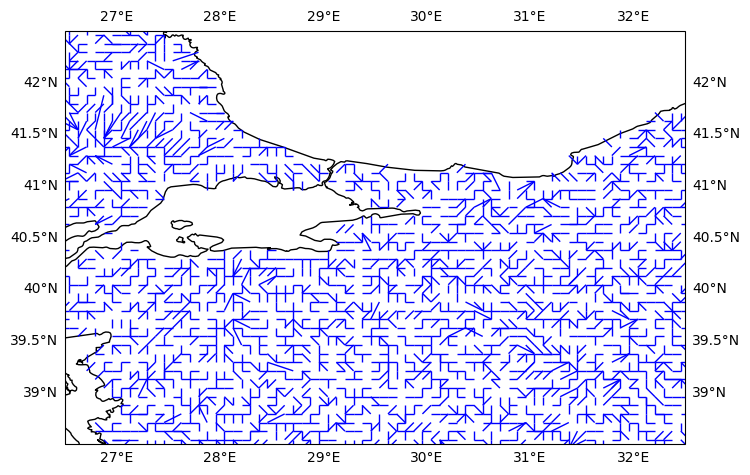

CPU times: user 1.91 s, sys: 341 ms, total: 2.25 s
Wall time: 1.87 s


In [7]:
%time plot_cropped_river_network(riv_nxtxy_cropped, left, right, bottom, top)

In [8]:
# discharge
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000 # m3/year

In [9]:
def plot_cropped_river_network_discharge(riv_nxtxy_cropped, rivout_cropped,
                                         left, right, bottom, top,
                                         projection=ccrs.PlateCarree(),
                                         line_color='blue', min_width=0.1, max_width=2.5, 
                                         a=2160, b=4320):
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)

    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    # 緯度経度に変換
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    # 流量によって線の太さを決定
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川ネットワークの線分リスト
    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    # Cartopy を用いた描画
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    # 河川を描画
    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)

    # 地図の補助情報
    ax.coastlines()
    ax.gridlines(draw_labels=True, linestyle="dotted", linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+0.5, right-1.5, bottom+1.5, top-0.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

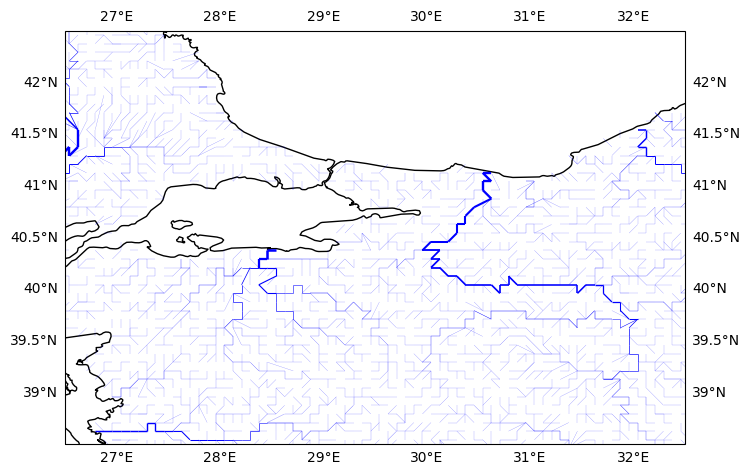

CPU times: user 2.38 s, sys: 303 ms, total: 2.68 s
Wall time: 2.3 s


In [10]:
%time plot_cropped_river_network_discharge(riv_nxtxy_cropped, rivout_cropped, left, right, bottom, top)

In [11]:
# rivnum
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]

In [12]:
def plot_cropped_river_network_discharge_basin(riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                                           left, right, bottom, top,
                                           projection=ccrs.PlateCarree(),
                                           line_color='blue', min_width=0.1, max_width=2.5, 
                                           a=2160, b=4320, min_basin_size=10):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする

    # **流域ごとに色を設定**
    unique_basins_filtered = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)])
    cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色
    norm = mcolors.BoundaryNorm(unique_basins_filtered, cmap.N)  # 流域番号を正規化

    # **流域マップの描画**
    lats = np.linspace(top, bottom, H + 1)
    lons = np.linspace(left, right, W + 1)
    mesh = ax.pcolormesh(lons, lats, rivnum_filtered, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree(), alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+0.5, right-1.5, bottom+1.5, top-0.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()


/tmp/ipykernel_385/2002668312.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色


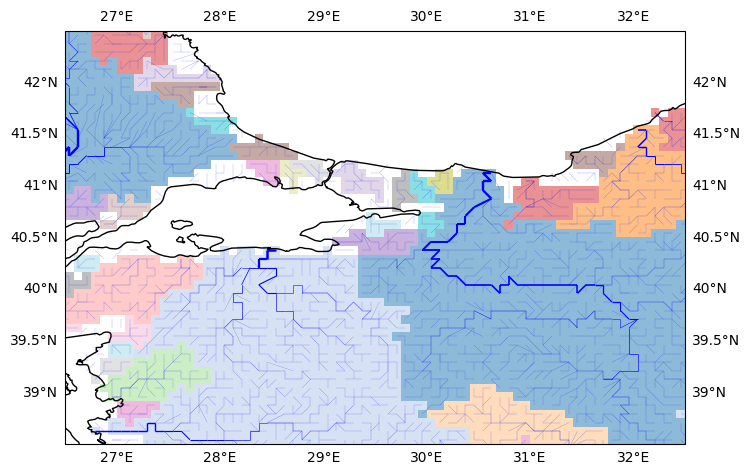

CPU times: user 407 ms, sys: 352 ms, total: 760 ms
Wall time: 378 ms


In [13]:
%time plot_cropped_river_network_discharge_basin(riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, min_basin_size=5)

In [14]:
def plot_riverend(riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                   left, right, bottom, top,
                   projection=ccrs.PlateCarree(),
                   line_color='blue', min_width=0.1, max_width=2.5, 
                   a=2160, b=4320, min_basin_size=5, end_marker_color='white'):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする

    # **流域ごとに色を設定**
    unique_basins_filtered = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)])
    cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色
    norm = mcolors.BoundaryNorm(unique_basins_filtered, cmap.N)  # 流域番号を正規化

    # **流域マップの描画**
    lats = np.linspace(top, bottom, H + 1)
    lons = np.linspace(left, right, W + 1)
    mesh = ax.pcolormesh(lons, lats, rivnum_filtered, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree(), alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+0.5, right-1.5, bottom+1.5, top-0.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()


/tmp/ipykernel_385/3213389494.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色


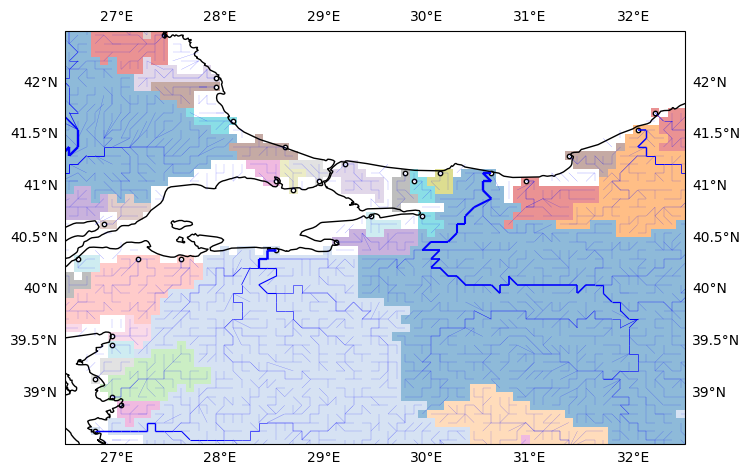

CPU times: user 418 ms, sys: 343 ms, total: 761 ms
Wall time: 400 ms


In [15]:
%time plot_riverend(riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, min_basin_size=5)

In [16]:
def plot_river_city(city_cropped,
                    riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                    left, right, bottom, top,
                    projection=ccrs.PlateCarree(),
                    line_color='blue', min_width=0.1, max_width=2.5, 
                    a=2160, b=4320, min_basin_size=5, end_marker_color='white'):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする

    # **流域ごとに色を設定**
    unique_basins_filtered = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)])
    cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色
    norm = mcolors.BoundaryNorm(unique_basins_filtered, cmap.N)  # 流域番号を正規化

    # **流域マップの描画**
    lats = np.linspace(top, bottom, H + 1)
    lons = np.linspace(left, right, W + 1)
    mesh = ax.pcolormesh(lons, lats, rivnum_filtered, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree(), alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # city mask
    draw_mask_sotowaku([left, right, bottom, top], city_cropped, ax=ax, sotowaku_color='red', inner_color='red', linewidth=1)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+0.5, right-1.5, bottom+1.5, top-0.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

/tmp/ipykernel_385/2747437818.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色


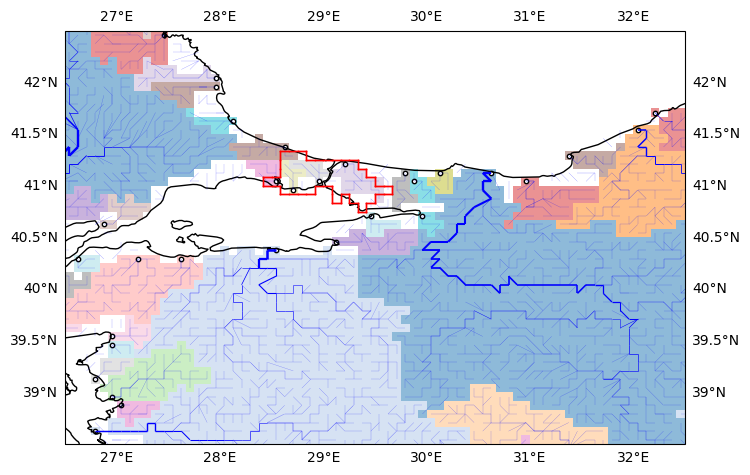

CPU times: user 531 ms, sys: 300 ms, total: 831 ms
Wall time: 448 ms


In [17]:
%time plot_river_city(mask_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, min_basin_size=5)

In [26]:
# 50l Domestic level1
# 100l Domestic level2 
# 293l All needs, level1
# 406l All needs, level2

# 各グリッドの色分けをどうするか

# population
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
poptot_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
poptot = np.fromfile(poptot_path, dtype='float32').reshape(2160, 4320) 
poptot_cropped = poptot[upperindex:lowerindex, leftindex:rightindex]

# discharge
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] 
rivout_meter = rivout_cropped * 60 * 60 * 24 * 365 / 1000 # kg/s -> m3/year

# mask
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
mask_path = f'{h08dir}/camacity/dat/cty_msk_/city_clrd0000.gl5'
mask = np.fromfile(mask_path, dtype='float32').reshape(2160, 4320) 
mask_cropped = mask[upperindex:lowerindex, leftindex:rightindex]
mask_cropped = np.where(mask_cropped==city_num, 1, 0)

# city population
city_pop = np.sum(poptot_cropped[mask_cropped==1])

# coloring
label_name = ['dom_level1', 'dom_level2', 'all_level1', 'all_level2']
label_list = [50, 100, 293, 406]

# liter/capita/day
availability = rivout_cropped*60*60*24 / city_pop

def first_availability(city_cropped,
                    riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                    availability,
                    left, right, bottom, top,
                    projection=ccrs.PlateCarree(),
                    line_color='blue', min_width=0.1, max_width=2.5, 
                    a=2160, b=4320, min_basin_size=5, end_marker_color='white'):

    # general
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    # resoluation
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]
    
    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # **availability（可用性データ）の描写**
    label_list = [50, 100, 293, 406]
    cmap = ListedColormap(['darked', 'red', 'orange', 'yellow', 'lightblue'])  # 5段階の色
    norm = BoundaryNorm([0] + label_list + [np.max(availability)], cmap.N)  # 境界設定

    im = ax.pcolormesh(np.linspace(left, right, availability.shape[1]), 
                        np.linspace(bottom, top, availability.shape[0]),
                        availability, 
                        cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    # カラーバーを追加
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', label='Availability')
    cbar.set_ticks(label_list)  # カラーバーの目盛りを調整

    # city mask
    draw_mask_sotowaku([left, right, bottom, top], city_cropped, ax=ax, sotowaku_color='red', inner_color='red', linewidth=1)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+0.5, right-1.5, bottom+1.5, top-0.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

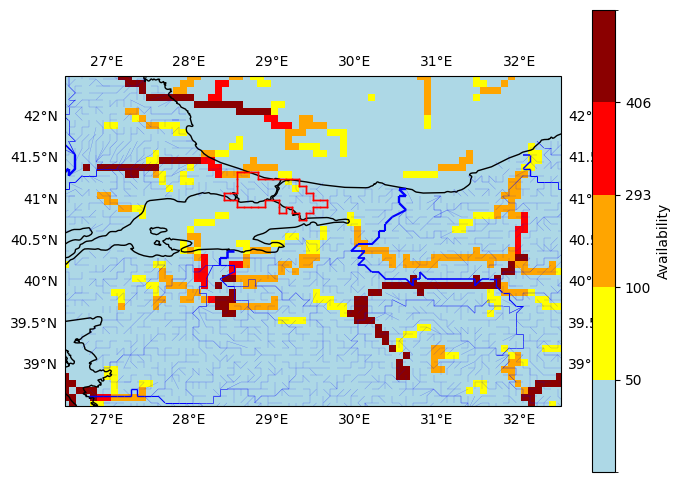

CPU times: user 503 ms, sys: 365 ms, total: 868 ms
Wall time: 514 ms


In [29]:
%time first_availability(mask_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, availability, left, right, bottom, top)

In [ ]:
def updown(new_basin_to_cities, uid_str='3.0', distance=100, riv_num=3):
    # get cities in basin
    city_list = new_basin_to_cities[uid_str]
    city_list = [int(i) for i in city_list]
    print(f'city_list: {city_list}')
    
    # remove overlap
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    city_list_removed = [num for num in city_list if num not in numbers]
    city_list_removed = [int(i) for i in city_list_removed]
    print(f'city_list_removed: {city_list_removed}')
    
    # rivnextlonlat 
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)
    
    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    
    # coord of purificication
    coords_a = []
    for city_num in city_list_removed:
        # rivnum
        rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
        rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)

        # prf
        prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)

        # int
        int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        
        # 1. prfとintどちらもが対象領域内(uid_int)でprfが大きい
        # 2. prfとintどちらもが対象領域内(uid_int)でintが大きい
        # 3. prfのみが対象流域内(uid_int)
        # 4. intのみが対象流域内(uid_int)
        uid_int = int(riv_num)
        flag, largest, all_int, prf_copy = prf_int_flag(prf, intake, uid_int, rivnum_gl5, rivout_gl5)
        largest_coord = np.where(largest==1)
        print(f'largest_coord{largest_coord}, city_num: {city_num}, uid_int: {uid_int}')
        coords_a.append([largest_coord, city_num])
        
    ####################################################################################
    # 同流域内で取水点がかぶっている都市を取水点ごとにリストにする
    ####################################################################################

    # 同じ座標に対して city_num のリストを作成するための辞書
    same_coords_dict = defaultdict(list)

    # coords_a の要素をループして座標をキーに city_num をリストに追加
    for coord, city_num in coords_a:
        for i in range(len(coord[0])):
            coord_tuple = (coord[0][i], coord[1][i])
            same_coords_dict[coord_tuple].append(city_num)
            
    ####################################################################################
        
    # down
    edges = []
    riv_path_array = np.zeros((2160, 4320))
    
    # city_num loop 
    for idx in range(len(coords_a)):

        # init
        visited_coords = set()
        
        # upstream
        cityup = coords_a[idx][1]
        
        # coords_a[idx][0] = (array([732]), array([3086]))
        riv_path_array[coords_a[idx][0][0][0], coords_a[idx][0][1][0]] = idx

        # coordinates of prf and intake
        coords_b = coords_a.copy()
        coords_b.pop(idx) 

        # main loop
        if len(coords_a) > 0:
            target_coord = (coords_a[idx][0][0][0], coords_a[idx][0][1][0])
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                
                next_coord = riv_nxlonlat_cropped[target_coord[0], target_coord[1]]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                
                next_coord = (next_coord[0], next_coord[1])
                riv_path_array[next_coord[0], next_coord[1]] = idx
                target_coord = next_coord

        for coord in coords_b:
            citydwn = coord[1]
            
            if coord[0][0].size == 0:
                continue
            else:
                standard_coord = (coord[0][0][0], coord[0][1][0])
                if standard_coord in visited_coords:
                    edge_flag = is_valid_edge(cityup, citydwn, same_coords_dict)
                    print(f'cityup: {cityup}, citydwn: {citydwn}, edge_flag: {edge_flag}')
                    if edge_flag:
                        edges.append((cityup, citydwn))
                    else:
                        continue
                else:
                    continue
                    
    # edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
    return edges, riv_path_array, coords_a, city_list_removed

In [22]:
def draw_rivseq():
    city_num = 15
    left, right, bottom, top = 26, 34, 37, 43
    leftlim, rightlim, bottomlim, toplim = 27, 32, 39, 43
    img_extent = (left, right, bottom, top)
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    ###########################################################################################

    # rivnum
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    
    # discharge
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000
    
    # rivnxl
    path_dict = get_rivpath_all(city_num, upperindex, lowerindex, leftindex, rightindex)
    
    ###########################################################################################

    pprf_dct = {}
    sprf_dct = {}
    ibt_dct = {}

    sub_rivnum_list = []
    
    # prf
    prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
    prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]

    pprf_coord = np.where(prf_cropped == 1)[0]
    sprf_coord = np.where(prf_cropped == 1)[1:]
    
    ###########################################################################################
    
    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['red', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#edb69b'])
    srivnum_cmap = mcolors.ListedColormap(['#f1d89c'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], projection)

    # rivnxl
    width = 1
    
    path_city_dict = path_dict[city_num]
    
    for key, path_coords in path_city_dict.items():
        
        #2つずつのペアに変換
        path_coords_lat = [coord[0] for coord in path_coords]
        path_coords_lon = [coord[1] for coord in path_coords]
        path_coords_pairs = list(zip(path_coords_lat, path_coords_lon))
        path_coords_grouped = [(path_coords_lat[i:i + 2], path_coords_lon[i:i + 2]) for i in range(len(path_coords) - 1)]
        
        for lat_coords, lon_coords in path_coords_grouped:
            # dischargeの取得
            discharge = rivout_cropped[lat_coords[0], lon_coords[0]]
            if discharge > 1e9:
                linewidth = 2.0
            else:
                linewidth = 0.5
            
            # lat_coordsとlon_coordsの変換
            lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
            
            # ax.plotを使ってプロット
            ax.plot(lon_coords, lat_coords, 
                    markersize=0, linewidth=linewidth, color='#57acff',
                    marker='o', linestyle='-', transform=projection, zorder=1
                   )

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=1, cmap=rivnum_cmap, transform=projection, extent=img_extent
                  )

    for srn in sub_rivnum_list:
        srivnum_masked = np.ma.masked_where(rivnum_cropped != srn, rivnum_cropped)
        ax.imshow(srivnum_masked, 
                  alpha=1, cmap=srivnum_cmap, transform=projection, extent=img_extent
                  )

    # city outer
    msk_dir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_'
    ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
    citymask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
    citymask_cropped = citymask[upperindex:lowerindex, leftindex:rightindex]
    draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='white', linewidth=1.5)
        
    # prf
    pprf_latlon = [grid_to_latlon(coord[0][0], coord[1][0], img_extent) for _, coord in pprf_dct.items()]
    pprf_lon, pprf_lat = zip(*pprf_latlon)
    ax.scatter(pprf_lon, pprf_lat, c=target_mpcy, s=pop_size, 
            cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), zorder=3)

    # secondary prf
    sprf_latlon = [
        [grid_to_latlon(c[0], c[1], img_extent) for c in zip(coord[0], coord[1])] if coord is not None else [(None, None)] 
        for n, coord in sprf_dct.items()
    ]
    
    for coord_list in sprf_latlon:
        for lon, lat in coord_list:
            if lon is not None and lat is not None:
                ax.plot(lon, lat, marker='x', color='#c700fe', markersize=3, 
                        transform=ccrs.PlateCarree(), zorder=2)

    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3,edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)

    west, east, south, north = leftlim, rightlim, bottomlim, toplim
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    
    gl = ax.gridlines(draw_labels=True, zorder=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(round(west/10)*10, east, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(round(south/10)*10, north, 10))
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size': 20, 'color': 'black'}
    gl.ylabel_style = {'size': 20, 'color': 'black'}
    
    ax.gridlines(visible=False)
    ax.spines['geo'].set_visible(True)
    
    plt.show()